In [17]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from pandas_datareader import data
import fix_yahoo_finance as yf

import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
news = pd.read_csv('seekingalpha_top.csv', index_col=[0], parse_dates=['date'])
comments = pd.read_csv('seekingalpha_top_comments.csv', index_col=[0], parse_dates=['datetime'])

In [19]:
symbols = news.symbol[np.logical_not(news.symbol.isna())]

In [20]:
# first we will consider only symbols with more than 9 explicit mentioning in our dataset
universe = symbols.unique()[(symbols.value_counts() > 10)]

In [21]:
# lets leave only relevant news
filtered_news = news[news.symbol.apply((lambda x: x in universe))]

### First we will construct a class to visualy evaluate our models on history data

Important to note, that this evaluation should be performed after model selection step, which should include train and test split or some crossvalidation scheme

In [22]:
class InvestmentSimulator():
    def __init__(self, universe, start_date, sumulation_start_delay, end_date, force_download=False):
        """ INPUT:
                universe - a list of strings with ticker symbols 
                start_date - a pandas Date object with starting date of simulation
                sumulation_start_delay - an integer number of days to skip in simulation 
                                        (will load data for previous to start_date *sumulation_start_delay* number of days) 
                finish_date - a pandas Date object with end date of the simulation
        """
        
        if(not force_download):
            try:
                self.close_prices = pd.read_csv('prices_tmp.csv', index_col=[0], parse_dates=['Date'])
            except FileNotFoundError:
                self.close_prices = yf.download(universe, 
                                            data_source = 'yahoo', 
                                            start=start_date - pd.Timedelta(sumulation_start_delay, unit='d'), 
                                            end=end_date)['Close'].dropna(axis=1) # we will drop any stock with missing 
                                                                                  # info, for simplicity
                self.close_prices.to_csv('prices_tmp.csv')
        else:
            self.close_prices = yf.download(universe, 
                                            data_source = 'yahoo', 
                                            start=start_date, 
                                            end=end_date)['Close'].dropna(axis=1) # we will drop any stock with missing 
                                                                                  # info, for simplicity
            self.close_prices.to_csv('prices_tmp.csv')
            
        self.universe = np.array(self.close_prices.columns)
        
        self.filtered_news = news[news.symbol.apply(lambda x: x in self.universe)]
        
        self.start_date = start_date
        self.sumulation_start_delay = sumulation_start_delay
        self.end_date = end_date
        
        self.CalculateReturns()
        

    def CalculateReturns(self, ndays=30):
        returns = [np.zeros(len(self.universe))]
        for day, previous_day in zip(np.arange(1, len(self.close_prices)), np.arange(0, len(self.close_prices) - 1)):
            returns.append(np.array((self.close_prices.iloc[day] - self.close_prices.iloc[previous_day]) / 
                                    self.close_prices.iloc[previous_day]))

        self.returns = pd.DataFrame(returns, index=self.close_prices.index, columns=self.close_prices.columns)
    
    def run(self, stock_balancer):
        """ A function that runs the simulation and calculates returns 
            INPUT:
                stock_balancer - a function with takes current date as input and returns a numpy array
                                 with proportions to balance portfolio of securities across universe
                                 date is an integer index of close_price dataframe
            OUTPUT:
                portfolio_value - a pandas series with portfolio value in dollars for each simulation day
        """
        
        # utility variable
        day = pd.Timedelta(1, unit='d')
        
        # we will ignore the fact that we can not buy less than one share
        # (we will assume we can split our porfolio in any proportion across desired stocks)
        portfolio_value = [1.]
        
        # in the begining we own all securities equally
        self.curent_portfolio = (np.ones(len(self.universe)) / len(self.universe)) / np.array(self.close_prices.iloc[0])
        
        for date in tqdm.tqdm_notebook(np.arange(self.sumulation_start_delay, len(self.close_prices.index))):
            proportions = stock_balancer(date)
            
            portfolio_value.append(portfolio_value[-1] + 
                                   np.sum(self.curent_portfolio * np.array(self.returns.iloc[date])))
            
            self.curent_portfolio = proportions
                        
        return pd.Series(data=portfolio_value[:-1], index=self.close_prices.index[self.sumulation_start_delay:])

As an example, lets see what happens if we simlply invest in all assets uniformly:

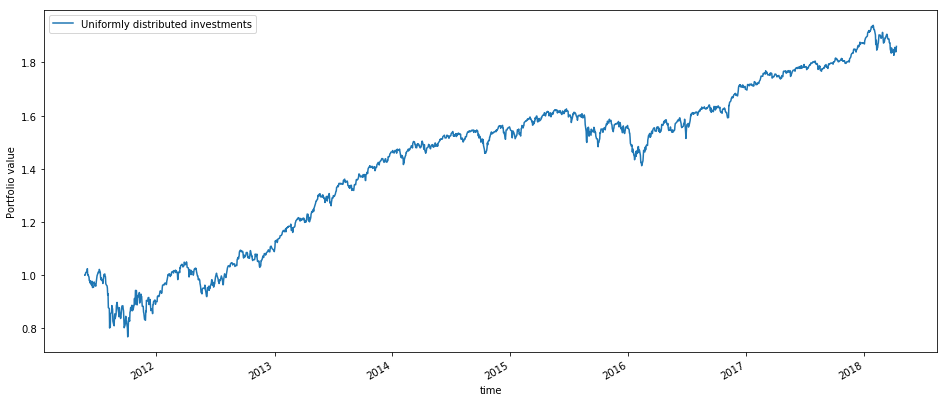

In [23]:
IS = InvestmentSimulator(universe=universe.tolist(), 
                         start_date=min(filtered_news.date.dt.date), 
                         sumulation_start_delay = 30,
                         end_date=max(filtered_news.date.dt.date) + pd.Timedelta(10, unit='d'),
                         force_download=False)

def plot_r(results):
    fig = plt.figure(figsize=(16, 7));
    ax = fig.add_subplot(111);
    for result in results:
        result['data'].plot(ax=ax, label=result['label']);
    ax.set_xlabel('time');
    ax.set_ylabel('Portfolio value');
    ax.legend();

def BuyEqual (date):
    return np.ones(len(IS.universe)) / len(IS.universe)

result = IS.run(BuyEqual)
results = [{'data':result, 'label':'Uniformly distributed investments'}]

plot_r(results)

### Now we construct the first variant of dataset based on news titles only:

In [24]:
class tfidf_dataset():
    """
        This is a class that constructs and stores dataset of features extracted from news.
        We fit a TfidfVectorizer on train_news. Then we construct train and test datasets, in which 
        datapoint (X, y) is the following:
        X - a scipy sparce matrix of shape (*number of securities*, n_features). Each line j is a sum of 
            feature vectors, extracted from news for the previous *lookback* days related to security j 
        y - a vector of lenght *number of securities* which contains returns for each security
    """
    def __init__(self, news, test_ratio, n_features, lookback = 30):
    
        self.train_news = news[:int((1. - test_ratio)*len(news))]
        self.test_news = news[int((1. - test_ratio)*len(news)):]
        
        self.lookback = lookback
        
        self.tfv = TfidfVectorizer(max_features=n_features, 
                                   analyzer='char', 
                                   ngram_range=(2, 5))
        
        self.tfv.fit(self.train_news.title)
        
        print('Constructing train dataset...', end='')
        self.train_dataset = self.construct_dataset(self.train_news)
        print('Done')
        print('Constructing test dataset...', end='')
        self.test_dataset = self.construct_dataset(self.test_news)
        print('Done')
        
    def construct_dataset(self, news):
        dataset = []

        relevant_prices_mask = np.logical_and(IS.close_prices.index > min(news.date), 
                                              IS.close_prices.index < max(news.date) + pd.Timedelta(self.lookback, unit='d'))
        
        for date in IS.close_prices.index[relevant_prices_mask]:
            news_chunk = news[np.logical_and(news.date > date - pd.Timedelta(self.lookback, unit='d'), 
                                             news.date <= date)]
            bag_of_news = (pd.Series(data='', index=IS.universe) + 
                           news_chunk.groupby('symbol')['title'].agg('\n'.join)).fillna('')
            
            X = self.tfv.transform(bag_of_news)
            y = IS.returns.loc[date]
            
            dataset.append((X, y))
        
        return dataset

In [25]:
dataset = tfidf_dataset(news = IS.filtered_news, test_ratio=0.5, n_features=2000)

Constructing train dataset...Done
Constructing test dataset...Done


### Lets do some simple algorithms, just to make sure that problem can not be solved head on:

In [26]:
from sklearn.linear_model import Ridge

R = Ridge()

In [32]:
# for faster training, lets flatten all X and concatenate whole dataset into one sparce matrix:
X_train = []
y_train = []

for X, y in dataset.train_dataset:
    X_train.append(sp.sparse.csr_matrix(X.toarray().reshape(-1)))
    y_train.append(np.array(y))

y_train = np.vstack(y_train)
X_train = sp.sparse.vstack(X_train)

In [28]:
R.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
X_test = []
y_test = []

for X, y in dataset.test_dataset:
    X_test.append(sp.sparse.csr_matrix(X.toarray().reshape(-1)))
    y_test.append(np.array(y))

y_test = np.vstack(y_test)
X_test = sp.sparse.vstack(X_test)

In [30]:
R.score(X_test, y_test)

-0.348267803597474

Not surprisingly, we wont get results with just ridge regression

In [33]:
from sklearn.tree import DecisionTreeRegressor

In [35]:
TR = DecisionTreeRegressor()

In [36]:
TR.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [37]:
TR.score(X_test, y_test)

-1.1139166525621385

In [42]:
y_train_classification = (y_train >= 0).astype(int)
y_test_classification = (y_test >= 0).astype(int)

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [46]:
TC = DecisionTreeClassifier()
TC.fit(X_train, y_train_classification)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [47]:
TC.score(X_test, y_test_classification)

0.0

In [55]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train_classification)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
RFC.score(X_test, y_test_classification)

0.0